In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install kaggle

In [ ]:
%cd /content/gdrive/MyDrive/AIPI540_code

/content/gdrive/MyDrive/AIPI540_code


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/AIPI540_code/"

In [ ]:
!kaggle datasets download -d skooch/ddsm-mammography

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /content/gdrive/MyDrive/AIPI540_code/. Or use the environment method.


In [ ]:
!unzip ddsm-mammography.zip

unzip:  cannot find or open ddsm-mammography.zip, ddsm-mammography.zip.zip or ddsm-mammography.zip.ZIP.


In [17]:
import cv2
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

In [4]:
print(tf.__version__)

2.8.0


In [5]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))
    
    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }   

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
      #print(image_features['label'].numpy())
      if image_features['label'].numpy() == 0:
        continue
      image = image_features['image'].numpy()
      image = tf.io.decode_raw(image_features['image'], tf.uint8)
      image = tf.reshape(image, [299, 299])        
      image=image.numpy()
      image=cv2.resize(image,(128,128))
      image=cv2.merge([image,image,image])        
      #plt.imshow(image)
      images.append(image)
      labels.append(image_features['label'].numpy())

In [6]:
negative_images = []
negative_labels = []
def read_data_negative(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))
    
    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }   

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    step = 0
    for image_features in full_dataset:
      #print(image_features['label'].numpy())
      if image_features['label'].numpy() == 0:
        step += 1

        if step > 1500:
          break
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])        
        image=image.numpy()
        image=cv2.resize(image,(224, 224))
        image=cv2.merge([image,image,image])        
        #plt.imshow(image)
        negative_images.append(image)
        negative_labels.append(0)

In [7]:
benign_images = []
benign_labels = []
malig_images = []
malig_labels = []
def read_data_benign(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))
    
    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }   

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
      #print(image_features['label'].numpy())
      if image_features['label'].numpy() == 1 or image_features['label'].numpy() == 2:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])        
        image=image.numpy()
        image=cv2.resize(image,(224, 224))
        image=cv2.merge([image,image,image])        
        benign_images.append(image)
        benign_labels.append(1)

def read_data_malig(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))
    
    feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }   

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print(full_dataset)
    for image_features in full_dataset:
      #print(image_features['label'].numpy())
      if image_features['label'].numpy() == 3 or image_features['label'].numpy() == 4:
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])        
        image=image.numpy()
        image=cv2.resize(image,(224, 224))
        image=cv2.merge([image,image,image])        
        malig_images.append(image)
        malig_labels.append(2)

In [37]:
filenames=['/content/aa/data/processed/training10_0/training10_0.tfrecords',
#          '../input/ddsm-mammography/training10_1/training10_1.tfrecords',
#           '../input/ddsm-mammography/training10_2/training10_2.tfrecords',
#           '../input/ddsm-mammography/training10_3/training10_3.tfrecords',
#           '../input/ddsm-mammography/training10_4/training10_4.tfrecords']
          ]

for file in filenames:
    read_data_negative(file)
    read_data_benign(file)
    read_data_malig(file)

DataLossError: ignored

In [9]:
images = negative_images + benign_images + malig_images
labels = negative_labels + benign_labels + malig_labels

In [10]:
print(labels.count(0))
print(labels.count(1))
print(labels.count(2))
#print(labels.count(3))
#print(labels.count(4))

1500
822
657


In [11]:
X=np.array(images)
y=np.array(labels)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

In [12]:
x_train, x_test = x_train/255.0, x_test/255.0

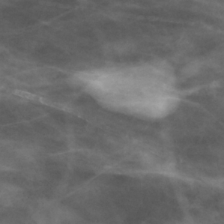

1


In [16]:
from google.colab.patches import cv2_imshow
cv2_imshow(x_train[22]*255)
print(y_train[22])
cv2.imwrite("mammo3.png", x_train[0]*255)

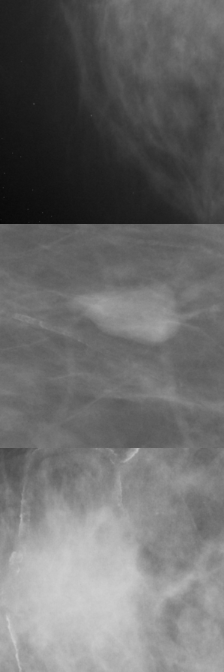

In [21]:
Hori = np.concatenate((x_train[21]*255, x_train[22]*255, x_train[20]*255), axis=0)
cv2_imshow(Hori)

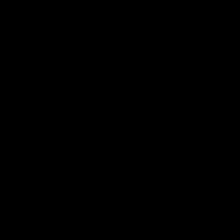

1


In [ ]:
index = 21
cv2_imshow(x_train[index])
print(y_train[index])

In [ ]:
import cv2
cv2.imwrite("mammo3.png", x_train[0]*255)

True

In [24]:
y_train = keras.utils.to_categorical(y_train, 3)
y_test = keras.utils.to_categorical(y_test, 3)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2383, 224, 224, 3)
(2383, 3)
(596, 224, 224, 3)
(596, 3)


In [7]:
from make_dataset import create_image_and_labels, create_train_and_test_data
images, labels = create_image_and_labels(['/content/gdrive/MyDrive/AIPI540_code/AIPI540_data/training10_0/training10_0.tfrecords'])

Size of Training Dataset:  11177
<ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Size of Training Dataset:  11177
<ParallelMapDataset element_spec={'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'label_normal': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [15]:
x_train, x_test, y_train, y_test = create_train_and_test_data(images, labels)

In [18]:
input_shape = (224, 224, 3)
num_classes = 3


patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate 0.03
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 224  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 32
num_epochs = 20
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output


class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(name='bias_table',
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchMerging, self).__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(input, output)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.Adam(
    learning_rate=learning_rate,   
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
    ],
)

checkpoint_filepath = "/saved_model"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=2,
    validation_split=validation_split,
    callbacks=[checkpoint_callback],
)

Epoch 1/2


KeyboardInterrupt: ignored

In [108]:
x_test[0]

array([[[0.49019608, 0.49019608, 0.49019608],
        [0.48627451, 0.48627451, 0.48627451],
        [0.48235294, 0.48235294, 0.48235294],
        ...,
        [0.47058824, 0.47058824, 0.47058824],
        [0.46666667, 0.46666667, 0.46666667],
        [0.4627451 , 0.4627451 , 0.4627451 ]],

       [[0.4745098 , 0.4745098 , 0.4745098 ],
        [0.47843137, 0.47843137, 0.47843137],
        [0.4745098 , 0.4745098 , 0.4745098 ],
        ...,
        [0.47058824, 0.47058824, 0.47058824],
        [0.46666667, 0.46666667, 0.46666667],
        [0.4627451 , 0.4627451 , 0.4627451 ]],

       [[0.4745098 , 0.4745098 , 0.4745098 ],
        [0.47843137, 0.47843137, 0.47843137],
        [0.4745098 , 0.4745098 , 0.4745098 ],
        ...,
        [0.4745098 , 0.4745098 , 0.4745098 ],
        [0.46666667, 0.46666667, 0.46666667],
        [0.45882353, 0.45882353, 0.45882353]],

       ...,

       [[0.56862745, 0.56862745, 0.56862745],
        [0.56078431, 0.56078431, 0.56078431],
        [0.56078431, 0

# Traditional ML

In [9]:
x_train_reshaped = x_train.reshape((x_train.shape[0], -1))
print(x_train_reshaped.shape)
x_test_reshaped = x_test.reshape((x_test.shape[0], -1))
print(x_test_reshaped.shape)

(2383, 150528)
(596, 150528)


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [11]:
rf_model = RandomForestClassifier()

In [12]:
rf_model.fit(x_train_reshaped, y_train)

RandomForestClassifier()

In [13]:
test_preds = rf_model.predict(x_test_reshaped)
print('traditional ML accuracy is: ', accuracy_score(test_preds,y_test))

traditional ML accuracy is:  0.5184563758389261


In [14]:
print(classification_report(test_preds,y_test))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       277
           1       0.22      0.55      0.31        64
           2       0.28      0.67      0.39        51

   micro avg       0.52      0.79      0.63       392
   macro avg       0.42      0.69      0.51       392
weighted avg       0.61      0.79      0.68       392
 samples avg       0.52      0.52      0.52       392



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(rf_model.predict(x_test_reshaped)[10])
print(y_test[10])

[0. 1. 0.]
[0. 0. 1.]


# Start the training

In [21]:
input_shape = (224, 224, 3)
num_classes = 3


patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate 0.03
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 224  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 32
num_epochs = 20
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

In [22]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

In [24]:
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(name='bias_table',
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

In [25]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

In [26]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchMerging, self).__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

In [27]:
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

In [53]:
model = keras.Model(input, output)


model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.Adam(
    learning_rate=learning_rate,   
    ),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),]
)

checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=40,
    validation_split=validation_split,
    callbacks=[checkpoint_callback],
)

Epoch 1/40
67/67 [==============================] - 55s 748ms/step - loss: 0.8635 - accuracy: 0.6129 - val_loss: 0.8883 - val_accuracy: 0.6444
Epoch 2/40
67/67 [==============================] - 49s 730ms/step - loss: 0.8589 - accuracy: 0.6269 - val_loss: 0.9357 - val_accuracy: 0.6234
Epoch 3/40
67/67 [==============================] - 49s 730ms/step - loss: 0.8471 - accuracy: 0.6301 - val_loss: 0.8535 - val_accuracy: 0.6402
Epoch 4/40
67/67 [==============================] - 49s 732ms/step - loss: 0.8388 - accuracy: 0.6320 - val_loss: 0.8500 - val_accuracy: 0.6527
Epoch 5/40
67/67 [==============================] - 49s 729ms/step - loss: 0.8401 - accuracy: 0.6432 - val_loss: 0.8814 - val_accuracy: 0.6402
Epoch 6/40
67/67 [==============================] - 49s 730ms/step - loss: 0.8358 - accuracy: 0.6535 - val_loss: 0.8734 - val_accuracy: 0.6402
Epoch 7/40
67/67 [==============================] - 49s 731ms/step - loss: 0.8331 - accuracy: 0.6381 - val_loss: 0.8466 - val_accuracy: 0.6611

In [1]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

NameError: ignored

In [36]:
#model.load_weights(checkpoint_filepath)
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
#print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

19/19 [==============================] - 4s 170ms/step - loss: 0.8012 - accuracy: 0.6779
Test loss: 0.8
Test accuracy: 67.79%


Last time, it was 87.72%

[[0.23422097 0.35977462 0.40600443]] predicted class is malignant
[0. 0. 1.] label is malignant


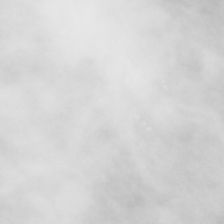

In [132]:
index = 41
print(model.predict(np.expand_dims(x_test[index], axis=0)), 'predicted class is malignant')
print(y_test[index], 'label is malignant')
cv2_imshow(x_test[index]*255)

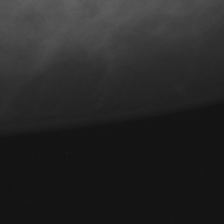

In [119]:
from google.colab.patches import cv2_imshow
cv2_imshow(x_test[1]*255)

In [134]:
cv2.imwrite("malignant2.png", x_test[41])

True

In [54]:
model.save('/content/gdrive/MyDrive/AIPI540_code/model_v3', save_format='tf')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/AIPI540_code/model_v3/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/AIPI540_code/model_v3/assets


In [ ]:
del model

In [34]:
model = keras.models.load_model('/content/gdrive/MyDrive/AIPI540_code/model_v3')

In [ ]:
!pip install -U ipykernel
!pip install -q streamlit
!pip install pyngrok

In [ ]:
%%writefile score.py

import tensorflow as tf
import numpy as np
import streamlit as st
from PIL import Image
import requests
from io import BytesIO

st.set_option('deprecation.showfileUploaderEncoding', False)
st.title('Mammography Classifier')
st.text('Provide URL of Mammography image')

@st.cache(allow_output_mutation=True)
def load_model():
  model = tf.keras.models.load_model('/content/newTransofmer/models')
  return model

with st.spinner('Loading Model Into Memory....'):
  model = load_model()

classes=['negative', 'benign calcification', 'benign mass', 
         'malignant calcification', 'malignant mass']

def scale(image):
  image = tf.cast(image, tf.float32)
  image /= 255.0
  return tf.image.resize(image, [128, 128])

def decode_img(image):
  img = tf.image.decode_jpeg(image, channels=3)
  img = scale(img)
  return np.expand_dims(img, axis=0)

path = st.text_input('Enter image URL to Classify.. ', 'http://undergradimaging.pressbooks.com/wp-content/uploads/sites/66470/2017/10/Mammography-images-a-300x244.png')
if path is not None:
  content = requests.get(path).content

  st.write('Predicted Class : ')
  with st.spinner('classifying...'):
    label = np.argmax(model.predict(decode_img(content)), axis=1)
    st.write(classes[label[0]])
  st.write("")
  image = Image.open(BytesIO(content))
  st.image(image, caption='Classifying Mammo Image', use_column_width=True)


Overwriting score.py


## Upload Model to GCP

In [32]:
from google.colab import auth
auth.authenticate_user()

In [33]:
!curl http://sdk.cloud.google.com | bash
!gcloud init

Streaming output truncated to the last 5000 lines.
google-cloud-sdk/lib/surface/resource_manager/folders/update.py
google-cloud-sdk/lib/surface/resource_manager/liens/__init__.py
google-cloud-sdk/lib/surface/resource_manager/liens/config/__init__.py
google-cloud-sdk/lib/surface/resource_manager/liens/config/export.yaml
google-cloud-sdk/lib/surface/resource_manager/liens/create.py
google-cloud-sdk/lib/surface/resource_manager/liens/delete.py
google-cloud-sdk/lib/surface/resource_manager/liens/list.py
google-cloud-sdk/lib/surface/resource_manager/operations/__init__.py
google-cloud-sdk/lib/surface/resource_manager/operations/describe.py
google-cloud-sdk/lib/surface/resource_manager/org_policies/__init__.py
google-cloud-sdk/lib/surface/resource_manager/org_policies/allow.py
google-cloud-sdk/lib/surface/resource_manager/org_policies/delete.py
google-cloud-sdk/lib/surface/resource_manager/org_policies/deny.py
google-cloud-sdk/lib/surface/resource_manager/org_policies/describe.py
google-clou

In [37]:
!gsutil cp -r /content/gdrive/MyDrive/AIPI540_code/model_v3 gs://swin_transformer

Copying file:///content/gdrive/MyDrive/AIPI540_code/model_v3/saved_model.pb [Content-Type=application/octet-stream]...
Copying file:///content/gdrive/MyDrive/AIPI540_code/model_v3/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file:///content/gdrive/MyDrive/AIPI540_code/model_v3/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file:///content/gdrive/MyDrive/AIPI540_code/model_v3/variables/variables.index [Content-Type=application/octet-stream]...
\
Operation completed over 4 objects/12.5 MiB.                                     


In [ ]:
%%writefile utils.py
# Utils for preprocessing data etc 
import tensorflow as tf
import googleapiclient.discovery
from google.api_core.client_options import ClientOptions

base_classes = ['negative', 'benign calcification', 'benign mass', 
         'malignant calcification', 'malignant mass']

classes_and_models = {
    "model_1": {
        "classes": base_classes,
        "model_name": "swin_transformer_1" # change to be your model name
    }
}

def predict_json(project, region, model, instances, version=None):
    """Send json data to a deployed model for prediction.
    Args:
        project (str): project where the Cloud ML Engine Model is deployed.
        model (str): model name.
        instances ([Mapping[str: Any]]): Keys should be the names of Tensors
            your deployed model expects as inputs. Values should be datatypes
            convertible to Tensors, or (potentially nested) lists of datatypes
            convertible to Tensors.
        version (str): version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the 
            model.
    """
    # Create the ML Engine service object
    prefix = "{}-ml".format(region) if region else "ml"
    api_endpoint = "https://{}.googleapis.com".format(prefix)
    client_options = ClientOptions(api_endpoint=api_endpoint)

    # Setup model path
    model_path = "projects/{}/models/{}".format(project, model)
    if version is not None:
        model_path += "/versions/{}".format(version)

    # Create ML engine resource endpoint and input data
    ml_resource = googleapiclient.discovery.build(
        "ml", "v1", cache_discovery=False, client_options=client_options).projects()
    instances_list = instances.numpy().tolist() # turn input into list (ML Engine wants JSON)
    
    input_data_json = {"signature_name": "serving_default",
                       "instances": instances_list} 

    request = ml_resource.predict(name=model_path, body=input_data_json)
    response = request.execute()
    
    # # ALT: Create model api
    # model_api = api_endpoint + model_path + ":predict"
    # headers = {"Authorization": "Bearer " + token}
    # response = requests.post(model_api, json=input_data_json, headers=headers)

    if "error" in response:
        raise RuntimeError(response["error"])

    return response["predictions"]

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=128, rescale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  """


  img = tf.io.decode_image(filename, channels=3) # make sure there's 3 colour channels (for PNG's)
  img = tf.cast(img, tf.float32)
  img = tf.image.resize(img, [img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  if rescale:
      img = img/255.
  else:
      img = img
  return np.expand_dims(img, axis=0).astype(np.int16)

Writing utils.py


In [ ]:
%%writefile app.py
import os
import json
import requests
import SessionState
import streamlit as st
import tensorflow as tf
from utils import load_and_prep_image, classes_and_models, predict_json

# Setup environment credentials (you'll need to change these)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "aipi-540-4a9a95f14ee5.json" # change for your GCP key
PROJECT = "AIPI 540" # change for your GCP project
REGION = "us-central1" # change for your GCP region (where your model is hosted)

### Streamlit code (works as a straigtht-forward script) ###
st.title("Welcome to Mammography Classifier 📸")
st.header("Identify what class it is for this mammography image!")

@st.cache # cache the function so predictions aren't always redone (Streamlit refreshes every click)
def make_prediction(image, model, class_names):
    """
    Takes an image and uses model (a trained TensorFlow model) to make a
    prediction.
    Returns:
     image (preproccessed)
     pred_class (prediction class from class_names)
     pred_conf (model confidence)
    """
    image = load_and_prep_image(image)
    
    preds = predict_json(project=PROJECT,
                         region=REGION,
                         model=model,
                         instances=image)
    pred_class = class_names[np.argmax(preds[0], axis=1)]
    return image, pred_class

# Pick the model version
choose_model = st.sidebar.selectbox(
    "Pick model you'd like to use",
    ("Model 1 (all mammo images)", # original 10 classes
)

# Model choice logic
if choose_model == "Model 1 (all mammo images)":
    CLASSES = classes_and_models["model_1"]["classes"]
    MODEL = classes_and_models["model_1"]["model_name"]
elif choose_model == "Model 2 (11 food classes)":
    CLASSES = classes_and_models["model_2"]["classes"]
    MODEL = classes_and_models["model_2"]["model_name"]
else:
    CLASSES = classes_and_models["model_3"]["classes"]
    MODEL = classes_and_models["model_3"]["model_name"]

# Display info about model and classes
if st.checkbox("Show classes"):
    st.write(f"You chose {MODEL}, these are the classes of images it can identify:\n", CLASSES)

# File uploader allows user to add their own image
uploaded_file = st.file_uploader(label="Upload an image of mammo image",
                                 type=["png", "jpeg", "jpg"])

# Setup session state to remember state of app so refresh isn't always needed
# See: https://discuss.streamlit.io/t/the-button-inside-a-button-seems-to-reset-the-whole-app-why/1051/11 
session_state = SessionState.get(pred_button=False)

# Create logic for app flow
if not uploaded_file:
    st.warning("Please upload an image.")
    st.stop()
else:
    session_state.uploaded_image = uploaded_file.read()
    st.image(session_state.uploaded_image, use_column_width=True)
    pred_button = st.button("Predict")

# Did the user press the predict button?
if pred_button:
    session_state.pred_button = True 

# And if they did...
if session_state.pred_button:
    session_state.image, session_state.pred_class = make_prediction(session_state.uploaded_image, model=MODEL, class_names=CLASSES)
    st.write(f"Prediction: {session_state.pred_class}")

Writing app.py
